In [2]:
import cv2
import os
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import random
random.seed(1)

## Fruit Image Classification 
Goal of this project is to build a model that successfully classifies images from 4 classes: Banana, Apple, Orange and Mixed (multiple fruit types). To train and test the model I will use Fruit dataset from Kaggle: https://www.kaggle.com/datasets/mbkinaci/fruit-images-for-object-detection.


In [3]:
print("Files in train set:", len(os.listdir("train_zip/train")))
print("Files in test set:", len(os.listdir("test_zip/test")))

Files in train set: 480
Files in test set: 120


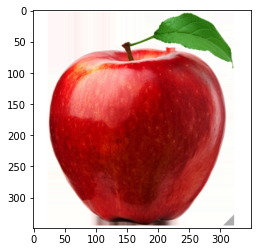

In [3]:
img = cv2.imread("train_zip/train/apple_1.jpg")[:,:,::-1]
plt.imshow(img)

Train images are saved in .jpg format with different resolutions. Before training the model we are going to preprocess them - by converting to grayscale, resizing to (50 x 50) and additionally extracting features with HOG algorithm.

In [4]:
from skimage.feature import hog
def hog_img(img, n):
    img = cv2.resize(img, (128, 64))
    fd, hog_image = hog(img, orientations = 8 , pixels_per_cell=(16, 16),
                    cells_per_block=(2, 2), visualize=True)
    hog_resized = cv2.resize(hog_image, (n,n))
    return(hog_resized)

In [5]:
def prepare(img, n = 200):
    img_transformed = hog_img(img, n)
    
    img1 = cv2.resize(img, (n, n))
    img2 = cv2.resize(img_transformed, (n,n))
    img2 = cv2.normalize(src = img2, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    return(np.concatenate([img1, img2], axis=0)) 

Example of preprocessed image with HOG algorithm:

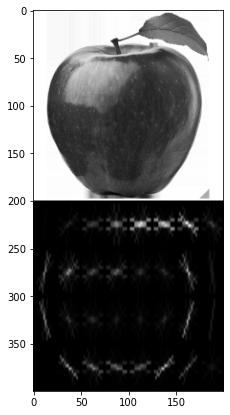

In [6]:
img = cv2.imread("train_zip/train/apple_1.jpg", cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(7, 7))
plt.imshow(prepare(img), cmap = "gray")

Reading images from train/test folders, preparing them and saving their labels:

In [7]:
X_train = []
y_train = []

X_test = []
y_test = []

n = 50
for img in os.listdir("train_zip/train"):
    if img[-3:] == "jpg":
        cv_img = cv2.imread("train_zip/train/" + img, cv2.IMREAD_GRAYSCALE)
        label = img.split("_")[0]
        
        X_train.append(prepare(cv_img, n))
        y_train.append(label)
        
for img in os.listdir("test_zip/test"):
    if img[-3:] == "jpg":
        cv_img = cv2.imread("test_zip/test/" + img, cv2.IMREAD_GRAYSCALE)
        label = img.split("_")[0]
        
        X_test.append(prepare(cv_img, n))
        y_test.append(label)

Let's see count plot of classes.

<AxesSubplot:ylabel='count'>

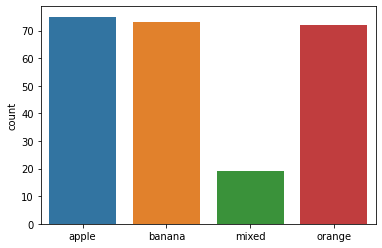

In [8]:
from seaborn import countplot
countplot(x = y_train)

We can notice that 'mixed' label is significantly underrepresented. To solve this issue we can try to do data augmentation for this class. We will create more training data from existing 'mixed' images - by rotating, flipping and blurring.

In [9]:
def rotation(img, angle):
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
    img = cv2.warpAffine(img, M, (w, h))
    return img

In [10]:
mixed = np.array(X_train)[np.array(y_train) == "mixed"]
for img in mixed:
    img = img[:n,:]
    angle = int(random.uniform(0,361))
    img_rotated = rotation(img, angle) 
    img_flipped = cv2.flip(img, 1)
    img_blurried = cv2.GaussianBlur(img, (3,3), 0)
    
    X_train.append(prepare(img_rotated, n))
    X_train.append(prepare(img_flipped, n))
    X_train.append(prepare(img_blurried, n))
    y_train.append("mixed")
    y_train.append("mixed")
    y_train.append("mixed")

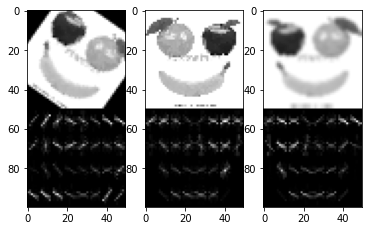

In [11]:
plt.subplot(1,3,1)
plt.imshow(X_train[-3].reshape(2*n,n), cmap = "gray")
plt.subplot(1,3,2)
plt.imshow(X_train[-2].reshape(2*n,n), cmap = "gray")
plt.subplot(1,3,3)
plt.imshow(X_train[-1].reshape(2*n,n), cmap = "gray")

Examples of transformations.

<AxesSubplot:ylabel='count'>

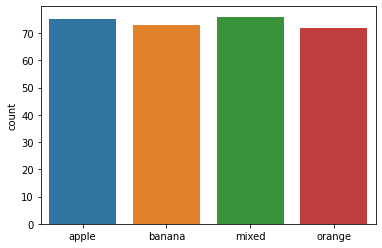

In [12]:
from seaborn import countplot
countplot(x = y_train)

After augmentation images in classes are equally distributed. Let's look at our training set and print some images.

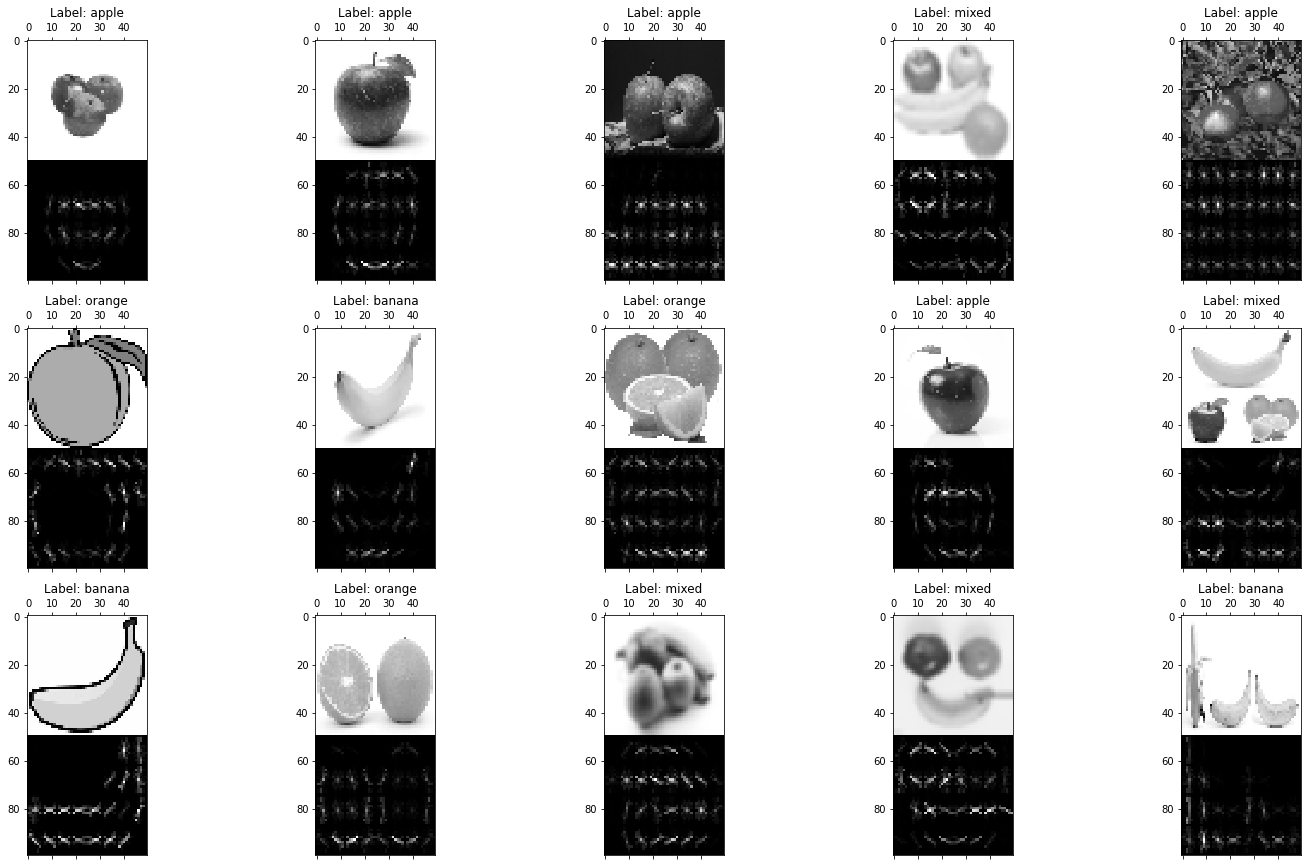

In [13]:
sample = random.sample(range(len(X_train)), k=15)

plt.figure(figsize=(25, 15))
for pos,index in enumerate(sample):
        plt.subplot(3,5,pos+1)
        plt.matshow(X_train[index], fignum=False, cmap = "gray")
        plt.title("Label: {}".format(y_train[index]))
plt.show()

## Model training

For classification model we will use simple machine learning algorithm - Support Vector Machine (SVM). Hyperparameter C will be chosen using GridSearchCV.

In [14]:
from sklearnex import patch_sklearn 
patch_sklearn()
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [15]:
x, y = X_train[0].shape
X_train = np.array(X_train).reshape(len(X_train), x*y)
X_test = np.array(X_test).reshape(len(X_test), x*y)

In [16]:
pipe = make_pipeline(StandardScaler(), SVC(probability = True))
param_grid = {
    "svc__C": [1,2,5,10,15]
}
search = GridSearchCV(pipe, param_grid)
search.fit(X_train, y_train)
print("Best parameter (CV score={}):".format(search.best_score_))
print(search.best_params_)
model = search.best_estimator_

Best parameter (CV score=0.7971186440677965):
{'svc__C': 2}


In [17]:
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.7833333333333333

The model scored 0.79 accuracy in 5-fold cross validation on training set, and 0.78 accuracy on test set. The confusion matrix and precision/recall table below show more datailed info about classification errors.

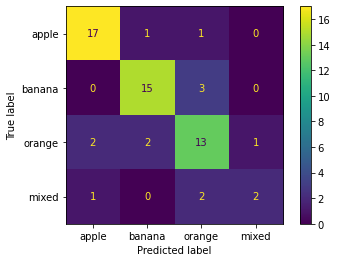

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

label_names = ['apple', 'banana', 'orange', 'mixed']
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels = label_names)
ConfusionMatrixDisplay(cm, display_labels = label_names).plot()

In [19]:
import pandas as pd

precision = np.diag(cm) / np.sum(cm, axis = 0) #axis 0 verical, axis 1 horizontal
recall = np.diag(cm) / np.sum(cm, axis = 1)

scores = pd.DataFrame({"precision": list(precision),
                      "recall": list(recall)}, index = label_names)
scores

,precision,recall
apple,0.850000,0.894737
banana,0.833333,0.833333
orange,0.684211,0.722222
mixed,0.666667,0.400000


We can notice 'orange' and 'mixed' labels have lower precision and recall scores. 
From all images classified as 'orange' 68% were actually oranges, and from all oranges 72% of them were correctly recognized as such. With mixed images it's 66% and 40% respectively.

Classifier provided 0.78 accuracy on test set, where apples and bananas were visibly better recognized and classified than the rest of classes. To increase model accuracy our next steps can include:  
* increasing size of training set
* further feature extraction
* classification using more sophisticated deep learning algorithms